In [688]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil as sh
import os
import statsmodels as sm

from calculate_dataset_measures import calculate as calculate_dataset_measures
from test import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [689]:
leps = [0, 0.25, 0.5, 0.75, 1]
biases = [-1, 0, 1]

In [690]:
# check if CSV file exists
if os.path.exists('predictions/dataset_measures.csv'):
    print('Dataset measures already calculated. If you want to recalculate, delete the file "predictions/seg_isic.csv"')
else:
  dataset_measures_df = pd.DataFrame()

  for lep in leps:
      for bias in biases:
          dataset_measures = calculate_dataset_measures('seg_isic', lep, bias)
          dataset_measures['lep'] = lep
          dataset_measures['bias'] = bias
          dataset_measures_df = pd.concat([dataset_measures_df, dataset_measures])

  os.makedirs('predictions', exist_ok=True)
  dataset_measures_df.to_csv('predictions/dataset_measures.csv', index=False)

Dataset measures already calculated. If you want to recalculate, delete the file "predictions/seg_isic.csv"


In [691]:
dataset_measures_df = pd.read_csv('predictions/dataset_measures.csv')
dataset_measures_df.head()
# TODO: Add subject ID to the dataset measures so it can be connected to plots below

,dsc,fpr,fnr,subject,lep,bias
0,1.0,0.0,0.0,ISIC_0000003,0.0,-1
1,1.0,0.0,0.0,ISIC_0000006,0.0,-1
2,1.0,0.0,0.0,ISIC_0000007,0.0,-1
3,1.0,0.0,0.0,ISIC_0000008,0.0,-1
4,1.0,0.0,0.0,ISIC_0000009,0.0,-1


In [692]:
for lep in leps:
  for bias in biases:
    if lep == 0 and bias != 0:
      continue
    log_name = f'isic_unet_1e-4_64_{int(lep*100)}_{bias}'
    if os.path.exists(f'predictions/{log_name}'):
      print(f'Predictions already calculated for {log_name}. If you want to recalculate, delete "predictions/{log_name}"')
    else:
      test(dataset='seg_isic', log_name=log_name)

Predictions already calculated for isic_unet_1e-4_64_0_0. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_0_0"
Predictions already calculated for isic_unet_1e-4_64_25_-1. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_25_-1"
Predictions already calculated for isic_unet_1e-4_64_25_0. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_25_0"
Predictions already calculated for isic_unet_1e-4_64_25_1. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_25_1"
Predictions already calculated for isic_unet_1e-4_64_50_-1. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_50_-1"
Predictions already calculated for isic_unet_1e-4_64_50_0. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_50_0"
Predictions already calculated for isic_unet_1e-4_64_50_1. If you want to recalculate, delete "predictions/isic_unet_1e-4_64_50_1"
Predictions already calculated for isic_unet_1e-4_64_75_-1. If you want to recalc

In [693]:
predictions_df = pd.DataFrame()
for lep in leps:
  for bias in biases:
    log_name = f'isic_unet_1e-4_64_{int(lep*100)}_{bias}'
    if os.path.exists(f'predictions/{log_name}/metrics_seg_isic.csv'):
        predictions = pd.read_csv(f'predictions/{log_name}/metrics_seg_isic.csv')
        predictions['lep'] = lep
        predictions['bias'] = bias
        predictions_df = pd.concat([predictions_df, predictions])
    else:
      print(f'Predictions not found for {log_name}')

Predictions not found for isic_unet_1e-4_64_0_-1
Predictions not found for isic_unet_1e-4_64_0_1


In [694]:
predictions_df.head()

,subject,dsc,hd,assd,prec,rec,fpr,fnr,lep,bias
0,ISIC_0000071,0.945741,7.071068,2.229845,0.897068,1.000000,0.114743,0.000000,0.0,0
1,ISIC_0000081,0.901653,48.466483,5.941351,0.841206,0.971459,0.183382,0.028541,0.0,0
2,ISIC_0000087,0.971713,19.104973,2.282775,0.985244,0.958549,0.014356,0.041451,0.0,0
3,ISIC_0000148,0.961129,7.615773,1.828165,0.990561,0.933395,0.008894,0.066605,0.0,0
4,ISIC_0000355,0.964335,9.899495,2.789881,0.996883,0.933845,0.002920,0.066155,0.0,0


Text(0.5, 0, 'LEP')

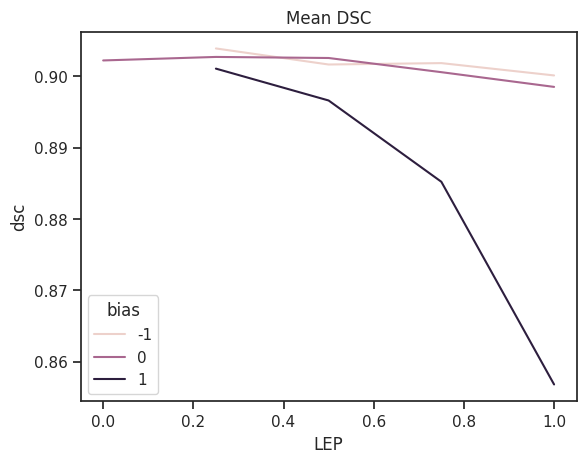

In [695]:
# Plot average DSC across LEPs
# Predictions df columns: subject, dsc, hd, assd, prec, rec, lep, bias

plot_df = predictions_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()

sns.lineplot(x='lep', y='dsc', hue='bias', data=plot_df)
plt.title('Mean DSC')
plt.xlabel('LEP')

Text(0.5, 0, 'LEP')

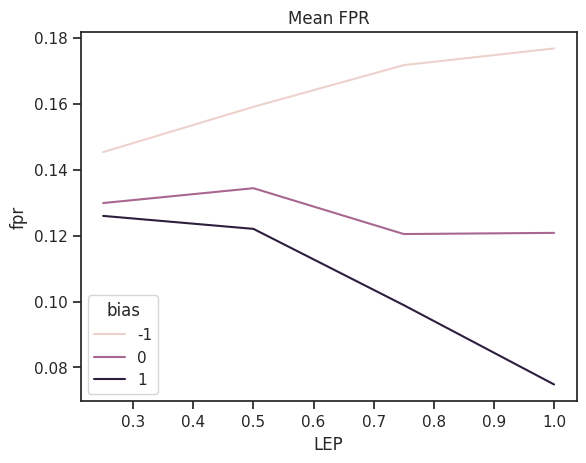

In [696]:
# Plot average FPR across dataset FPR
plot_df = predictions_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()
# Remove LEP = 0
plot_df = plot_df[plot_df.lep != 0]

sns.lineplot(x='lep', y='fpr', hue='bias', data=plot_df)
plt.title('Mean FPR')
plt.xlabel('LEP')

In [697]:
# rename dataset measures columns dsc, fnr, fpr to avoid confusion
dataset_measures_df = dataset_measures_df.rename(columns={'dsc': 'dsc_dataset', 'fnr': 'fnr_dataset', 'fpr': 'fpr_dataset'})
# join dataset measures and predictions
all_df = pd.merge(dataset_measures_df, predictions_df, on=['subject', 'lep', 'bias'])

In [698]:
len(all_df[all_df['fpr_dataset'] > 1]) / len(all_df)
# remove outliers
all_df = all_df[all_df['fpr_dataset'] <= 1]
all_df = all_df[all_df['fpr'] <= 1]
all_df = all_df[all_df['fnr'] <= 1]
all_df = all_df[all_df['fnr_dataset'] <= 1]
all_df = all_df[all_df['lep'] != 0]
all_df = all_df[all_df['fpr'] > 1e-6]
all_df = all_df[all_df['fnr'] > 1e-6]
all_df = all_df[all_df['fpr_dataset'] > 1e-6]
all_df = all_df[all_df['fnr_dataset'] > 1e-6]

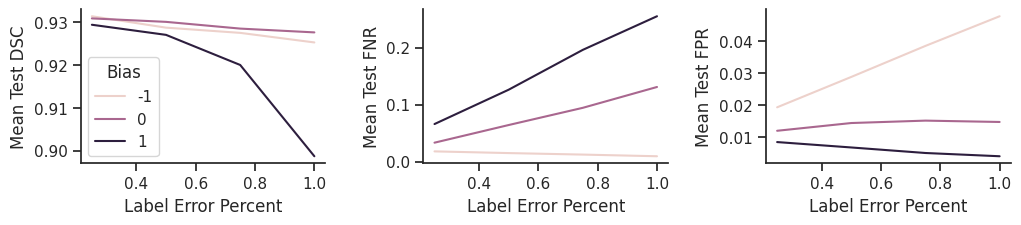

In [699]:
# plot mean DSC, FNR and FPR per LEP for each bias
sns.set(style="ticks")
plot_df = all_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()

colors = sns.color_palette()
# reordering the colors
colors = [colors[0], colors[2], colors[1]]

plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
sns.lineplot(x='lep', y='dsc', hue='bias', data=plot_df)
plt.xlabel('Label Error Percent')
plt.ylabel('Mean Test DSC')
sns.despine()
# Change legend title
plt.legend(title='Bias')

plt.subplot(1, 3, 2)
sns.lineplot(x='lep', y='fnr_dataset', hue='bias', data=plot_df)
plt.xlabel('Label Error Percent')
plt.ylabel('Mean Test FNR')
sns.despine()
# Remove legend
plt.legend([],[], frameon=False)

plt.subplot(1, 3, 3)
sns.lineplot(x='lep', y='fpr_dataset', hue='bias', data=plot_df)
plt.xlabel('Label Error Percent')
plt.ylabel('Mean Test FPR')
sns.despine()
plt.legend([],[], frameon=False)

# change spacing
plt.subplots_adjust(wspace=0.4)
# save plot
plt.savefig('figures/mean_line_plots.pdf', bbox_inches='tight')

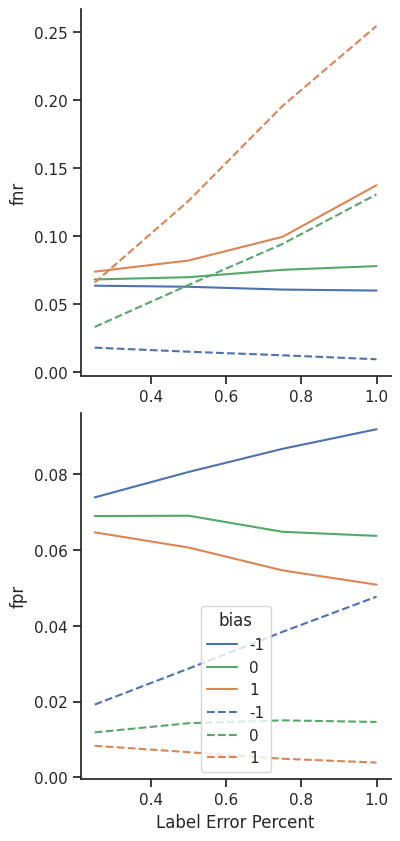

In [700]:
# plot mean DSC, FNR and FPR per LEP for each bias
sns.set(style="ticks")
plot_df = all_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()

colors = sns.color_palette()
# reordering the colors
colors = [colors[0], colors[2], colors[1]]

plt.figure(figsize=(4, 10))

plt.subplot(2, 1, 1)
sns.lineplot(x='lep', y='fnr', hue='bias', data=plot_df, palette=colors)
sns.lineplot(x='lep', y='fnr_dataset', hue='bias', data=plot_df, linestyle='dashed', palette=colors)
sns.despine()
plt.xlabel('')
# Remove legend
plt.legend([],[], frameon=False)

plt.subplot(2, 1, 2)
sns.lineplot(x='lep', y='fpr', hue='bias', data=plot_df, palette=colors)
sns.lineplot(x='lep', y='fpr_dataset', hue='bias', data=plot_df, linestyle='dashed', palette=colors)
sns.despine()
plt.xlabel('Label Error Percent')

# share x axis
plt.subplots_adjust(hspace=0.1)


In [701]:
# mean DSC across experiemnts (LEPs and biases)
plot_df = all_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()
print(len(plot_df))

12


In [702]:
# check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = plot_df[['fnr_dataset', 'fpr_dataset']].copy()
# center the data
vif_df = vif_df - vif_df.mean()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
vif["features"] = vif_df.columns
vif

,VIF Factor,features
0,2.006325,fnr_dataset
1,2.006325,fpr_dataset


In [703]:
# regression analysis
import statsmodels.api as sm
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE

plot_df = all_df.copy()
model = GEE.from_formula("fnr ~ fnr_dataset + fpr_dataset", groups=plot_df['subject'], data=plot_df, family=sm.families.Binomial(link=sm.families.links.logit()))
result = model.fit()
print(result.summary())
print(result.aic)


/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                         fnr   No. Observations:                27460
Model:                                 GEE   No. clusters:                     2805
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Binomial   Mean cluster size:                 9.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 27 May 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         12:52:09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.5786      0.040    -64.620      0.000      -2.657      -2.500
fnr_

In [704]:
# regression analysis
import statsmodels.api as sm
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE

plot_df = all_df.copy()

model = GEE.from_formula("fpr ~ fnr_dataset + fpr_dataset", groups=plot_df['subject'], data=plot_df, family=sm.families.Binomial(link=sm.families.links.logit()))
result = model.fit()
print(result.summary())
print(result.aic)

/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                         fpr   No. Observations:                27460
Model:                                 GEE   No. clusters:                     2805
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Binomial   Mean cluster size:                 9.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 27 May 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         12:52:10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.8455      0.037    -77.231      0.000      -2.918      -2.773
fnr_

In [705]:
# regression analysis
import statsmodels.api as sm
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE

plot_df = all_df.copy()


model = GEE.from_formula("dsc ~ fnr_dataset + fpr_dataset", groups=plot_df['subject'], data=plot_df, family=sm.families.Binomial(link=sm.families.links.logit()))
result = model.fit()
print(result.summary())
print(result.aic)

/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                         dsc   No. Observations:                27460
Model:                                 GEE   No. clusters:                     2805
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Binomial   Mean cluster size:                 9.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 27 May 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         12:52:10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7055      0.024    113.179      0.000       2.659       2.752
fnr_

In [706]:
# regression analysis
import statsmodels.api as sm
import pandas as pd
from statsmodels.genmod.generalized_estimating_equations import GEE

plot_df = all_df.copy()

model = GEE.from_formula("dsc_dataset ~ fnr_dataset + fpr_dataset", groups=plot_df['subject'], data=plot_df, family=sm.families.Binomial(link=sm.families.links.logit()))
result = model.fit()
print(result.summary())
print(result.aic)

/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:                 dsc_dataset   No. Observations:                27460
Model:                                 GEE   No. clusters:                     2805
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                  12
Family:                           Binomial   Mean cluster size:                 9.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Mon, 27 May 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         12:52:10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.8718      0.013    297.779      0.000       3.846       3.897
fnr_

/home/marinbenc/miniconda3/envs/pt2/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


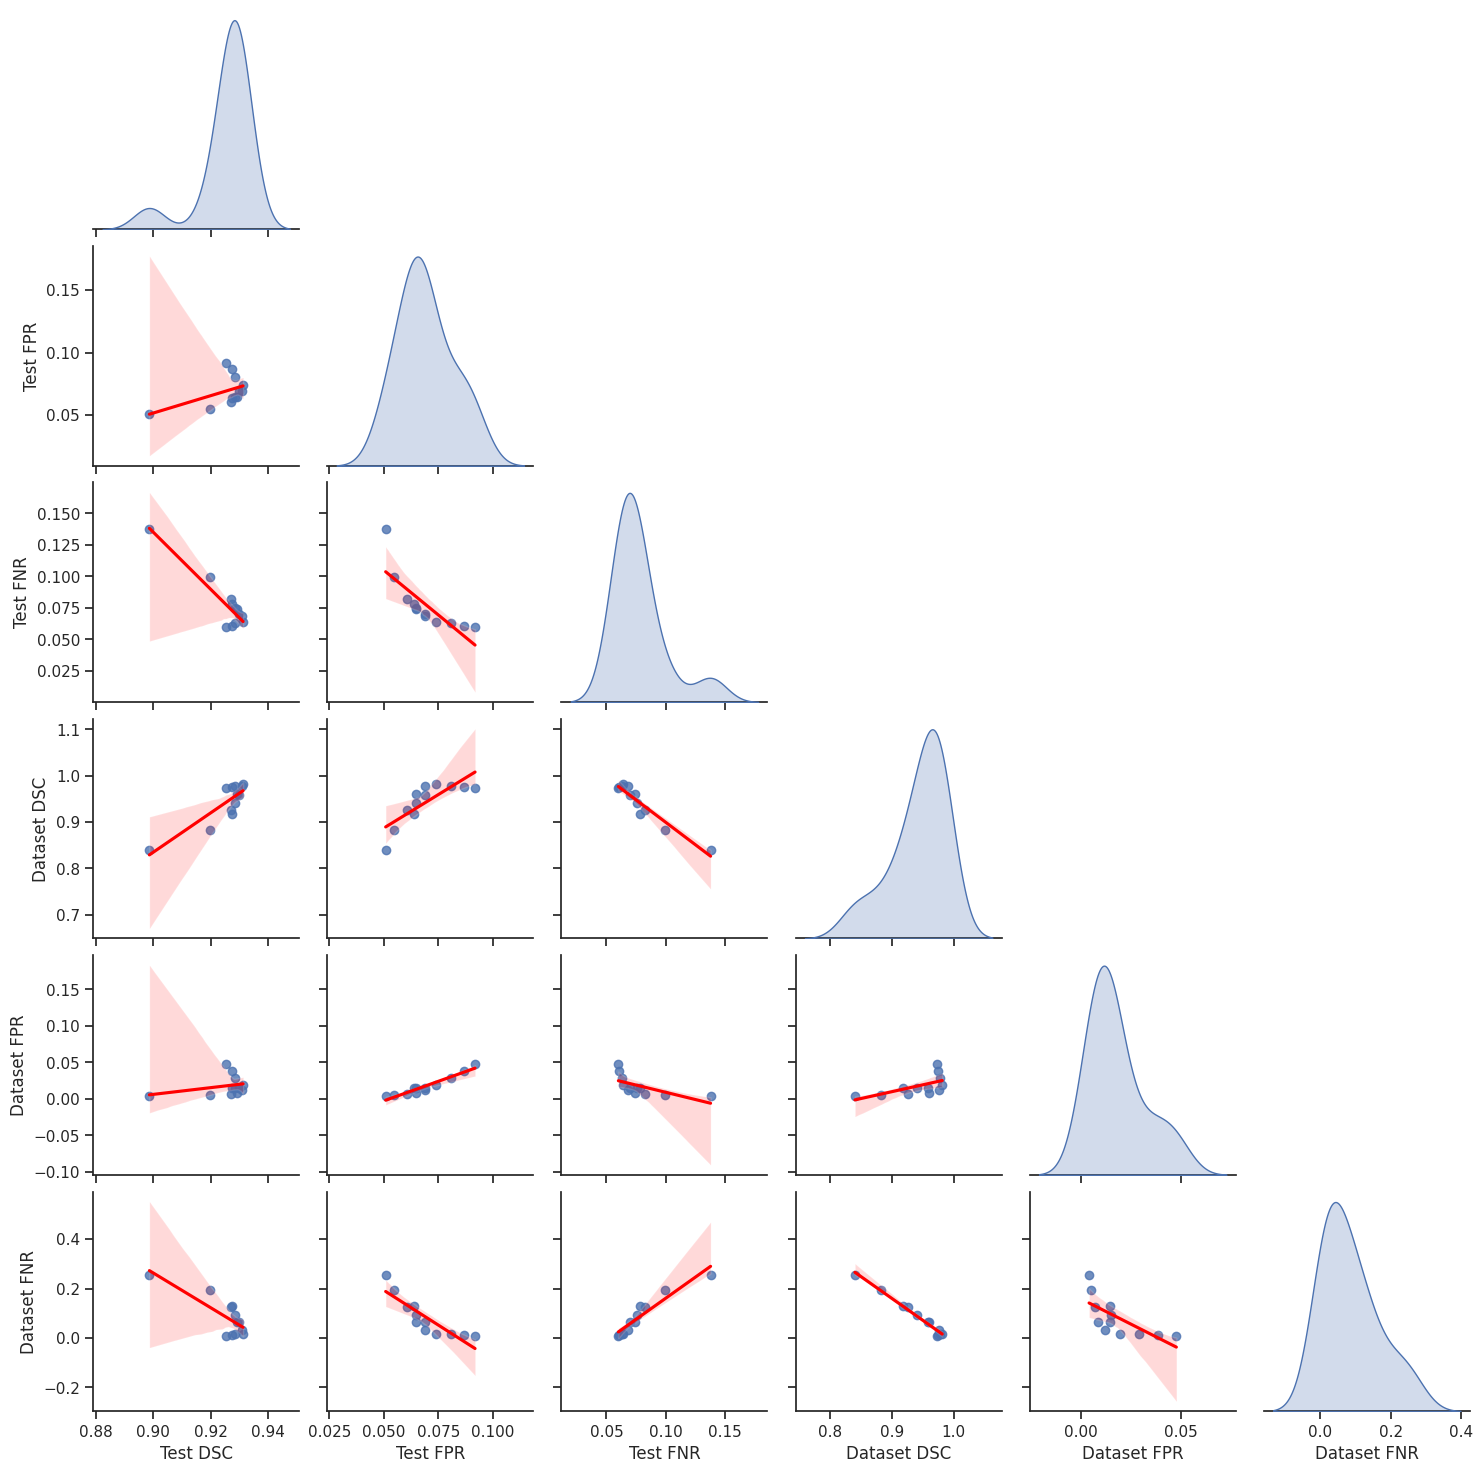

In [707]:
sns.set_style("ticks")
pairplot_df = all_df.copy()
pairplot_df = pairplot_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()
pairplot_df = pairplot_df.rename(columns={'dsc': 'Test DSC', 'fpr': 'Test FPR', 'fnr': 'Test FNR', 'dsc_dataset': 'Dataset DSC', 'fpr_dataset': 'Dataset FPR', 'fnr_dataset': 'Dataset FNR'})
sns.pairplot(pairplot_df[['Test DSC', 'Test FPR', 'Test FNR', 'Dataset DSC', 'Dataset FPR', 'Dataset FNR']], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}}, corner=True)

In [708]:
# calculate mean dataset FPR and dataset FNR and their standard deviations
print(f'Mean dataset FPR: {all_df["fpr_dataset"].mean():.3f} ± {all_df["fpr_dataset"].std():.3f}')
print(f'Mean dataset FNR: {all_df["fnr_dataset"].mean():.3f} ± {all_df["fnr_dataset"].std():.3f}')

Mean dataset FPR: 0.018 ± 0.026
Mean dataset FNR: 0.080 ± 0.111


In [709]:
# calculate correlation and p-value for each pair of variables
from scipy.stats import pearsonr

# correlation analysis
corr_df = all_df.copy()
corr_df = corr_df.groupby(['lep', 'bias']).mean(numeric_only=True).reset_index()



# Bonferroni correction for multiple comparisons
alpha = 0.05
n = 10
alpha = alpha / n

# Dataset DSC vs Dataset FPR
corr, p = pearsonr(plot_df['dsc_dataset'], plot_df['fpr_dataset'])
print(f'Dataset DSC vs Dataset FPR: correlation={corr}, p={p}')

# Dataset DSC vs Dataset FNR
corr, p = pearsonr(plot_df['dsc_dataset'], plot_df['fnr_dataset'])
print(f'Dataset DSC vs Dataset FNR: correlation={corr}, p={p}')

# Test DSC vs Dataset FPR
corr, p = pearsonr(plot_df['dsc'], plot_df['fpr_dataset'])
print(f'Test DSC vs Dataset FPR: correlation={corr}, p={p}')

# Test DSC vs Dataset FNR
corr, p = pearsonr(plot_df['dsc'], plot_df['fnr_dataset'])
print(f'Test DSC vs Dataset FNR: correlation={corr}, p={p}')

# Test FPR vs Dataset FPR
corr, p = pearsonr(plot_df['fpr'], plot_df['fpr_dataset'])
print(f'Test FPR vs Dataset FPR: correlation={corr}, p={p}')

# Test FNR vs Dataset FNR
corr, p = pearsonr(plot_df['fnr'], plot_df['fnr_dataset'])
print(f'Test FNR vs Dataset FNR: correlation={corr}, p={p}')

print('Alpha:', alpha)

Dataset DSC vs Dataset FPR: correlation=0.015250466417901412, p=0.011497740904914297
Dataset DSC vs Dataset FNR: correlation=-0.9693290235415044, p=0.0
Test DSC vs Dataset FPR: correlation=-0.13063094402202496, p=8.749792962501816e-105
Test DSC vs Dataset FNR: correlation=-0.10047230527156978, p=1.5287183434620661e-62
Test FPR vs Dataset FPR: correlation=0.2558772115656056, p=0.0
Test FNR vs Dataset FNR: correlation=0.13041790387960672, p=1.9056564677813203e-104
Alpha: 0.005


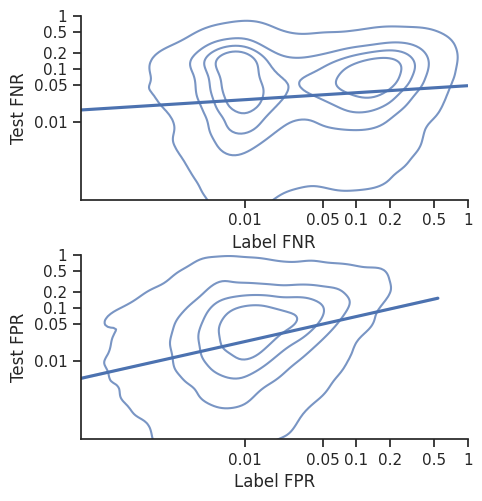

In [710]:
sns.set_style("ticks")

subjects = all_df['subject'].unique()
plot_df = all_df[all_df['fnr'] > 1e-6]
plot_df = plot_df[plot_df['fpr'] > 1e-6]
plot_df = plot_df[plot_df['fnr_dataset'] > 1e-6]
plot_df = plot_df[plot_df['fpr_dataset'] > 1e-6]
#plot_df = plot_df[all_df['subject'].isin(subjects)]

plot_df['fnr_log'] = np.log(plot_df['fnr'] + 1e-6)
plot_df['fnr_dataset_log'] = np.log(plot_df['fnr_dataset'] + 1e-6)
plot_df['fpr_log'] = np.log(plot_df['fpr'] + 1e-6)
plot_df['fpr_dataset_log'] = np.log(plot_df['fpr_dataset'] + 1e-6)

# plot FNR vs dataset FNR and FPR vs dataset FPR on the same plot
plt.figure(figsize=(5, 5.5))


# default colors
c1 = sns.color_palette()[0]
c2 = sns.color_palette()[1]

# two subplots
plt.subplot(2, 1, 1)
sns.kdeplot(x='fnr_dataset_log', y='fnr_log', data=plot_df, levels=5, label='FNR', color=c1, alpha=0.75)
sns.regplot(x='fnr_dataset_log', y='fnr_log', data=plot_df, scatter=False, ci=None, label='FNR', color=c1)
plt.xticks(np.log([0.01, 0.05, 0.1, 0.2, 0.5, 1]), [0.01, 0.05, 0.1, 0.2, 0.5, 1])
plt.yticks(np.log([0.01, 0.05, 0.1, 0.2, 0.5, 1]), [0.01, 0.05, 0.1, 0.2, 0.5, 1])
plt.xlim(-8, 0)
plt.ylim(-8, 0)
plt.xlabel('Label FNR')
plt.ylabel('Test FNR')
# turn off grid
plt.grid(False)
# despine
sns.despine()

plt.subplot(2, 1, 2)
sns.kdeplot(x='fpr_dataset_log', y='fpr_log', data=plot_df, levels=5, label='FPR', alpha=0.75, color=c1)
sns.regplot(x='fpr_dataset_log', y='fpr_log', data=plot_df, scatter=False, label='FPR', color=c1)
plt.xticks(np.log([0.01, 0.05, 0.1, 0.2, 0.5, 1]), [0.01, 0.05, 0.1, 0.2, 0.5, 1])
plt.yticks(np.log([0.01, 0.05, 0.1, 0.2, 0.5, 1]), [0.01, 0.05, 0.1, 0.2, 0.5, 1])
plt.xlim(-8, 0)
plt.ylim(-8, 0)
# turn off grid
plt.grid(False)
# despine
sns.despine()
plt.xlabel('Label FPR')
plt.ylabel('Test FPR')

# add vertical space between subplots
plt.subplots_adjust(hspace=0.3)

# save figure
plt.savefig('figures/fpr_fnr.pdf', bbox_inches='tight')

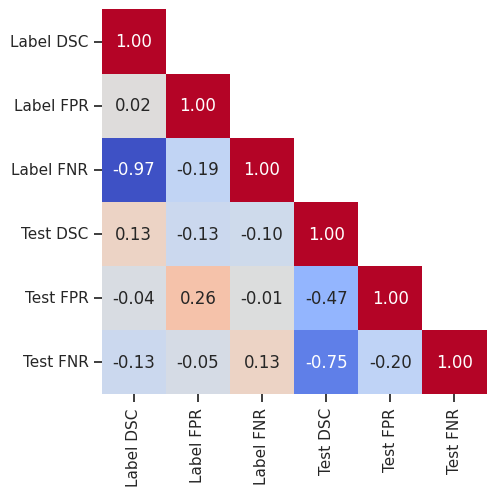

In [711]:
plt.figure(figsize=(10, 5))
plot_df = all_df.copy()

# remove LEP = 0
plot_df = plot_df[plot_df['lep'] > 0]

# diagonal mask
mask = np.triu(np.ones_like(plot_df[['dsc_dataset', 'fpr_dataset', 'fnr_dataset', 'dsc', 'fpr', 'fnr']].corr(), dtype=bool), k=1)

# Rename columns for better readability
plot_df = plot_df.rename(columns={'dsc': 'Test DSC', 'fpr': 'Test FPR', 'fnr': 'Test FNR', 'dsc_dataset': 'Label DSC', 'fpr_dataset': 'Label FPR', 'fnr_dataset': 'Label FNR'})
sns.heatmap(plot_df[['Label DSC', 'Label FPR', 'Label FNR', 'Test DSC', 'Test FPR', 'Test FNR']].corr(), 
  annot=True, mask=mask, cmap='coolwarm', center=0, square=True, fmt=".2f", cbar=False)
# save figure
plt.savefig('figures/correlation.pdf', bbox_inches='tight')

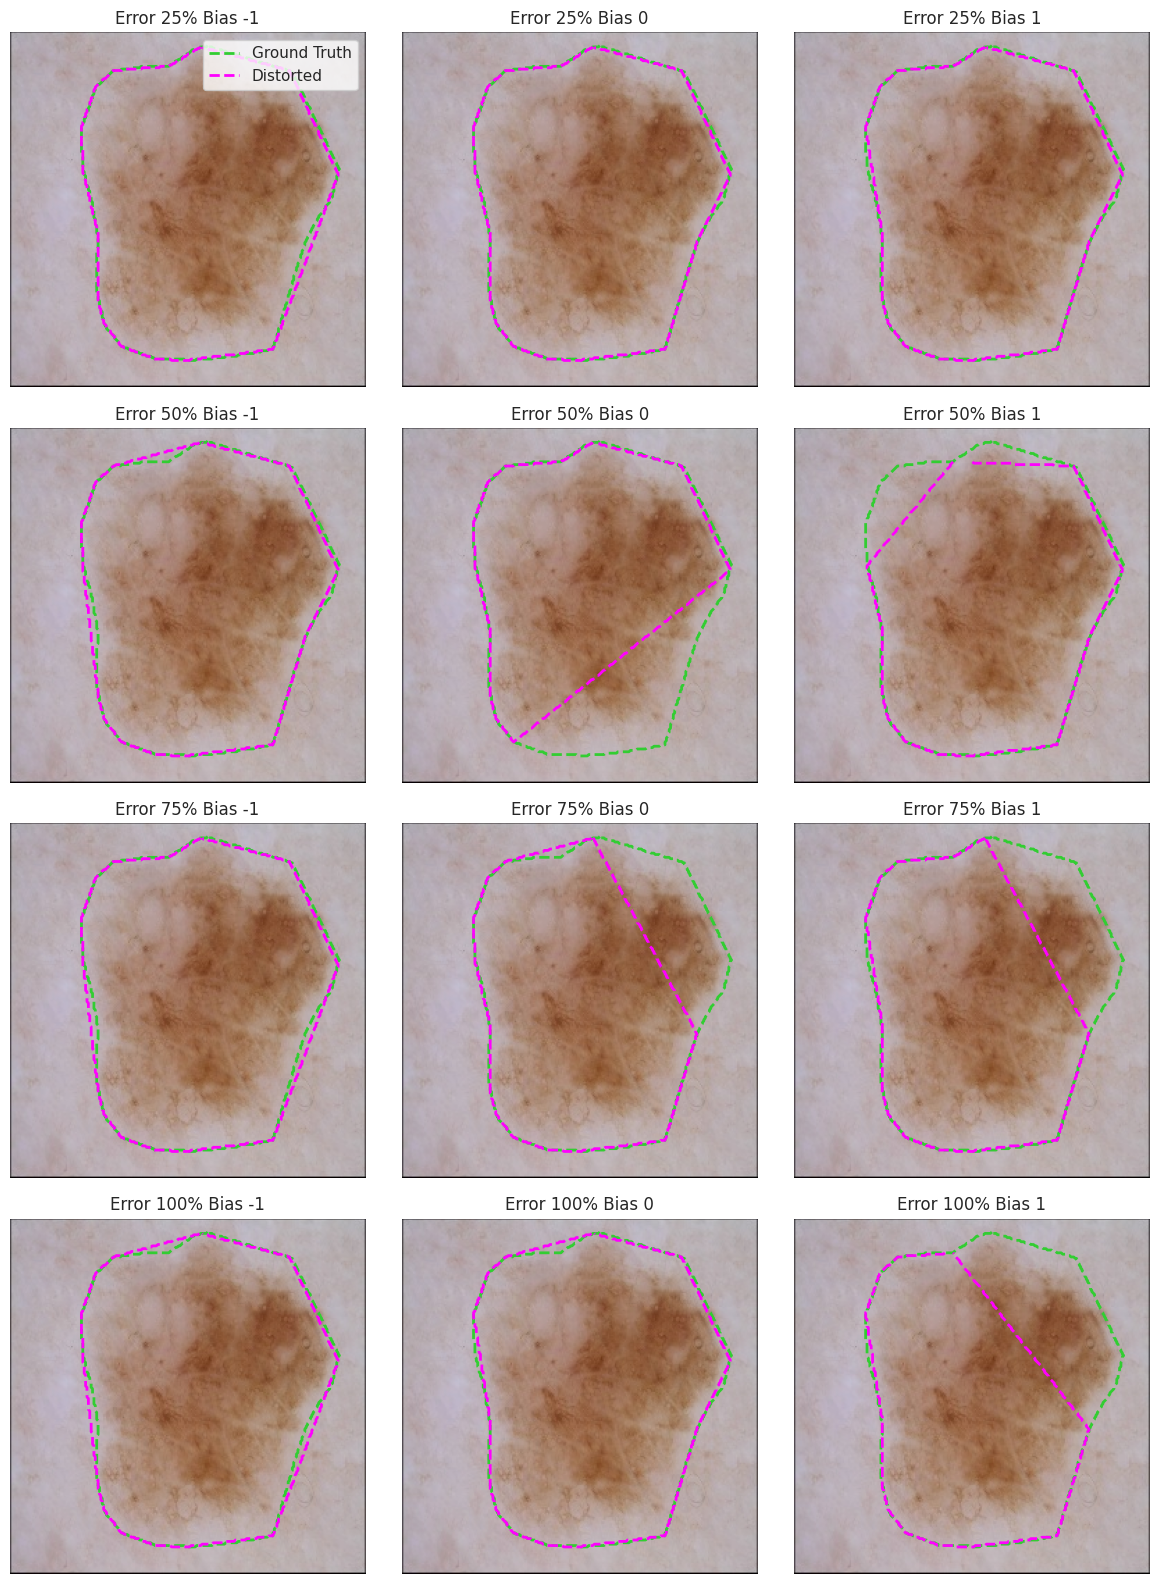

In [717]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys

from utils import fpr, fnr

image_name = 'ISIC_0000056.jpg'

# Set paths to the directories
image_dir = 'data/isic/test/input'
ground_truth_dir = 'data/isic/test/label'
base_distorted_dir = 'data/isic'
save_directory = 'plotted_imgs'

# Ensure save directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define error percentages and specific order of biases
label_error_percent = ['25', '50', '75', '100']
biases = ['-1', '0', '1']

# Prepare the paths
img_path = os.path.join(image_dir, image_name)
ground_truth_path = os.path.join(ground_truth_dir, image_name.replace('.jpg', '.png'))

if not os.path.exists(img_path) or not os.path.exists(ground_truth_path):
    print("Image or label not found.")
    sys.exit(1)

# Load the image and ground truth
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with 4 rows and 3 columns, each row for a different error percentage
fig, axs = plt.subplots(4, 3, figsize=(12, 16))  # Adjust the size as needed

for row_idx, percent in enumerate(label_error_percent):
    for col_idx, bias in enumerate(biases):
        distorted_label_path = os.path.join(base_distorted_dir, f'labels_{percent}_{bias}', image_name.replace('.jpg', '.png'))
        distorted_label = cv2.imread(distorted_label_path, cv2.IMREAD_GRAYSCALE)

        # Find contours for ground truth and distorted labels
        contours_gt, _ = cv2.findContours(ground_truth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_distorted, _ = cv2.findContours(distorted_label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        ax = axs[row_idx, col_idx]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Error {percent}% Bias {bias}')

        # Draw contours with matplotlib
        for contour in contours_gt:
            ax.plot(contour[:, :, 0], contour[:, :, 1], color='limegreen', linestyle='--', linewidth=2)
        for contour in contours_distorted:
            ax.plot(contour[:, :, 0], contour[:, :, 1], color='magenta', linestyle='--', linewidth=2)

        # Adding a custom legend
        if row_idx == 0 and col_idx == 0:
            ax.legend(['Ground Truth', 'Distorted'], loc='upper right')

plt.tight_layout()
save_path = os.path.join(save_directory, f'{os.path.splitext(image_name)[0]}_detailed_plots.png')
plt.show()
#plt.savefig(save_path, dpi=300)  # Save the figure with all plots
#plt.close(fig)  # Close the figure to free up memory

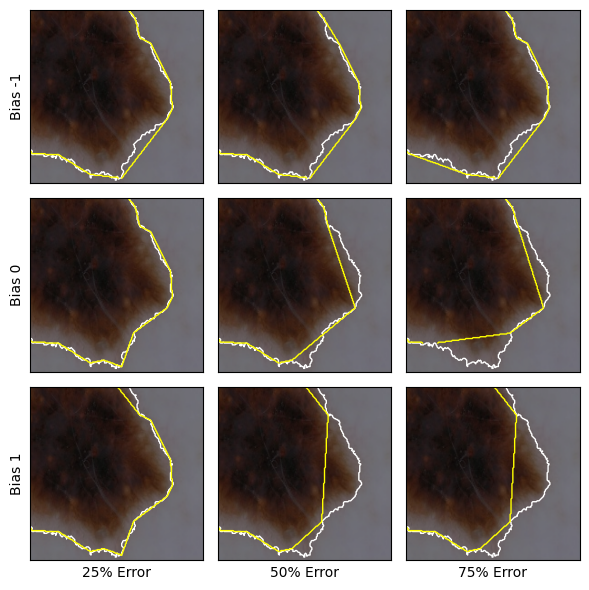

In [45]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys

from utils import fpr, fnr

image_name = 'ISIC_0000066.jpg'

# Set paths to the directories
image_dir = 'data/isic/test/input'
ground_truth_dir = 'data/isic/test/label'
base_distorted_dir = 'data/isic'

# Define error percentages and specific order of biases
label_error_percent = ['25', '50', '75']
biases = ['-1', '0', '1']

# Prepare the paths
img_path = os.path.join(image_dir, image_name)
ground_truth_path = os.path.join(ground_truth_dir, image_name.replace('.jpg', '.png'))

if not os.path.exists(img_path) or not os.path.exists(ground_truth_path):
    print("Image or label not found.")
    sys.exit(1)

# Load the image and ground truth
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

# reduce image contrast for better visualization
image = cv2.convertScaleAbs(image, alpha=0.5, beta=0)

# example
# 25% -1, 50% -1, 75% -1
# 25% 0, 50% 0, 75% 0
# 25% 1, 50% 1, 75% 1

fig, axs = plt.subplots(3, 3, figsize=(6, 6))

for row_idx, bias in enumerate(biases):
    for col_idx, percent in enumerate(label_error_percent):
        distorted_label_path = os.path.join(base_distorted_dir, f'labels_{percent}_{bias}', image_name.replace('.jpg', '.png'))
        distorted_label = cv2.imread(distorted_label_path, cv2.IMREAD_GRAYSCALE)

        # Find contours for ground truth and distorted labels
        contours_gt, _ = cv2.findContours(ground_truth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_distorted, _ = cv2.findContours(distorted_label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        ax = axs[row_idx, col_idx]
        ax.imshow(image)
        
        if row_idx == 2:
            ax.set_xlabel(f'{percent}% Error')
        if col_idx == 0:
            ax.set_ylabel(f'Bias {bias}')
        # remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Draw contours with matplotlib
        for contour in contours_gt:
            ax.plot(contour[:, :, 0], contour[:, :, 1], color='White', linewidth=1)
        for contour in contours_distorted:
            ax.plot(contour[:, :, 0], contour[:, :, 1], color='Yellow', linewidth=1)

        # zoom to top-right quadrant
        ax.set_xlim(64, 256)
        ax.set_ylim(0, 256-64)

plt.tight_layout()
plt.savefig('figures/error_example.pdf', bbox_inches='tight')

NameError: name 'percent_error' is not defined

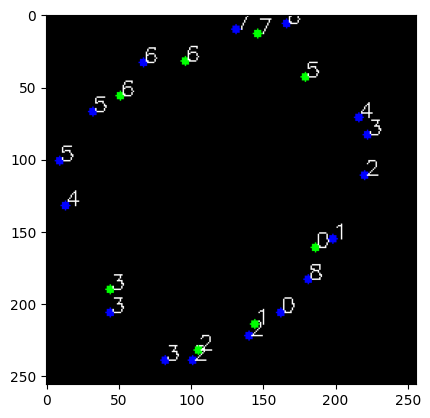

In [58]:
import cv2 as cv
from label_error_sim import get_simplified_label, get_max_distance, make_error_label, get_contour_polygon_points

gt_label = cv.imread('data/isic/test/label/ISIC_0000066.png', cv.IMREAD_GRAYSCALE)

points = get_contour_polygon_points(gt_label)

# draw points
viz_img = np.zeros((gt_label.shape[0], gt_label.shape[1], 3), np.uint8)
viz_img[gt_label > 128] = (255, 0, 0)
# for point in points:
#   gt_label = cv.circle(viz_img, tuple(point), 3, (0, 255, 0), -1)


viz_img = np.zeros((gt_label.shape[0], gt_label.shape[1], 3), np.uint8)
# draw convex hull
hull = cv.convexHull(points, returnPoints=False)

hull_points = []
for i in hull.squeeze():
  hull_points.append(points[i])
hull_points = np.array(hull_points)

# find defects
defects = cv.convexityDefects(points, hull)
if defects is not None:
  defect_points = points[defects[:, 0, 2]]
else:
  defect_points = np.empty((0, 2))

key_points = np.concatenate((hull_points, defect_points))
is_defect = np.zeros(len(key_points)).astype(bool)
is_defect[len(hull_points):] = 1

# sort key_points based on points
points = np.array(points)
sorting = np.zeros(len(key_points), np.uint8)
for idx in range(len(key_points)):
  # find closest point in points
  idx_in_points = np.argmin(np.linalg.norm(points - key_points[idx], axis=1))
  sorting[idx] = idx_in_points

sorting = np.argsort(sorting)
key_points = key_points[sorting]
is_defect = is_defect[sorting]

# shift so that key_points[0] is a defect point
if not is_defect[0]:
  key_points = np.roll(key_points, -1, axis=0)
  is_defect = np.roll(is_defect, -1, axis=0)

# make two arrays of groups of point indices
# one for hull points and one for defect points

hull_groups = []
defect_groups = []
group_idxs = np.zeros(len(key_points)).astype(int)

for i, point in enumerate(key_points):
  # check previous point
  if i > 0:
    # if point is in the same group as the previous point
    # otherwise, start a new group
    if is_defect[i] == is_defect[i - 1]:
      if is_defect[i]:
        defect_groups[-1].append(i)
      else:
        if len(hull_groups[-1]) >= 3:
          hull_groups.append([i]) # limit the maximum number of points in a hull group to 3
          group_idxs[i] = len(hull_groups) + len(defect_groups)
        else:
          hull_groups[-1].append(i)
    else:
      if is_defect[i]:
        defect_groups.append([i])
        group_idxs[i] = len(hull_groups) + len(defect_groups)
      else:
        hull_groups.append([i])
        group_idxs[i] = len(hull_groups) + len(defect_groups)
  else:
    if is_defect[i]:
      defect_groups.append([i])
      group_idxs[i] = len(hull_groups) + len(defect_groups)
    else:
      hull_groups.append([i])
      group_idxs[i] = len(hull_groups) + len(defect_groups)

# draw key points and label groups
for i, point in enumerate(key_points):
  if is_defect[i]:
    color = (0, 255, 0)
  else:
    color = (0, 0, 255)
  viz_img = cv.circle(viz_img, tuple(point), 3, color, -1)
  # draw group number
  viz_img = cv.putText(viz_img, str(group_idxs[i]), tuple(point), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

plt.imshow(viz_img)

n_groups_to_remove = round(len(defect_groups) * percent_error)
n_groups_to_remove = min(n_groups_to_remove, len(defect_groups))
n_groups_to_remove = max(n_groups_to_remove, 0)

hull_group_idxs_to_remove = []
defect_group_idxs_to_remove = []

if bias == 0:
  hull_group_idxs_to_remove = np.random.choice(len(hull_groups), n_groups_to_remove // 2, replace=False)
  defect_group_idxs_to_remove = np.random.choice(len(defect_groups), n_groups_to_remove // 2, replace=False)
elif bias == 1:
  hull_group_idxs_to_remove = np.random.choice(len(hull_groups), n_groups_to_remove, replace=False)
elif bias == -1:
  defect_group_idxs_to_remove = np.random.choice(len(defect_groups), n_groups_to_remove, replace=False)
else:
  raise ValueError('bias must be -1, 0, or 1')

hull_points_to_remove = [p for group in hull_group_idxs_to_remove for p in hull_groups[group]]
defect_points_to_remove = [p for group in defect_group_idxs_to_remove for p in defect_groups[group]]

# remove groups
new_key_points = []
for i, point in enumerate(key_points):
  if i not in hull_points_to_remove and i not in defect_points_to_remove:
    new_key_points.append(point)

new_key_points = np.array(new_key_points).astype(np.int32)

new_mask = np.zeros_like(gt_label)
new_mask = cv.fillPoly(new_mask, [new_key_points], 255)